# part0: imports

In [38]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs
        defs = monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "S3-monkey-behaviour.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.


In [41]:
@utility.report
def get_1session_monkey_data():
    full_list_MCx = []
    for animal, sessionList in SingleSessionEx.items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return allDFs_MCx

---

In [27]:
def plot_traj(ax, df):
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    colors = np.roll(utility.get_colors(defs.n_targets),3,axis=0)
    for i,traj in enumerate(df.pos):
        color = colors[df.target_id[i]]
        ax.plot(traj[:,0], traj[:,1], color=color, lw=.4)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
    ax.set_xticklabels(np.int16(ax.get_xticks()-ax.get_xticks().min()))
    ax.set_yticklabels(np.int16(ax.get_yticks()-ax.get_yticks().min()))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('$X (mm)$')
    ax.set_ylabel('$Y (mm)$')

Executed: `get_1session_monkey_data` in 10.6s


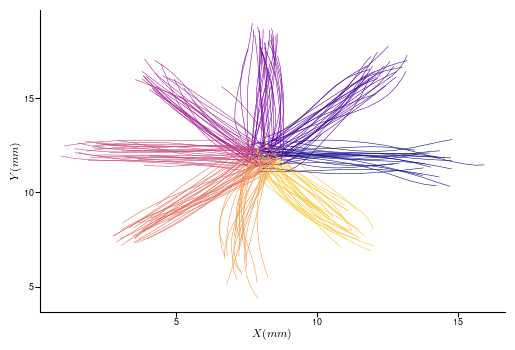

In [42]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    sessionDFs_MCx = get_1session_monkey_data()
    
    plot_traj(ax, sessionDFs_MCx[1])
    plt.show()

---
plot firing rates

In [49]:
def plot_mean_fr(ax, df, signal = 'M1_rates', **kwarg):
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    fr = pyal.get_average_firing_rates(df,signal)
    
    bins = np.arange(fr.min(), fr.max(), 2)
    
    ax.hist(fr, bins=bins, **kwarg)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(min_n_ticks=4, nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=6))
    ax.set_xlabel('mean firing rate ($1/s$)')
    ax.set_ylabel('\# of neurons')

Executed: `get_1session_monkey_data` in 50.9s


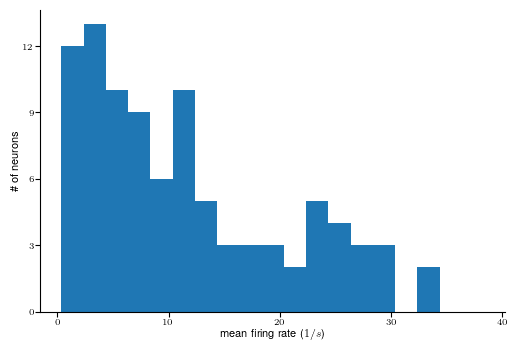

In [32]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    # sessionDFs_MCx = get_1session_monkey_data()

    plot_mean_fr(ax, sessionDFs_MCx[2])
    plt.show()

---
plot VAF distrbution

In [33]:
def plot_vaf(ax, df, field='M1_rates', **kwarg):
    n_components = 20
    
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
    
    line = ax.plot(np.arange(1,n_components+1), np.cumsum(rates_model.explained_variance_ratio_), **kwarg)

    ax.set_yticks(np.arange(0,1,.2))
    ax.set_ylim([0,.9])
    ax.set_xticks(np.arange(1,n_components+1,3))
    ax.set_xlabel('Neural modes')
    ax.set_ylabel('VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return line

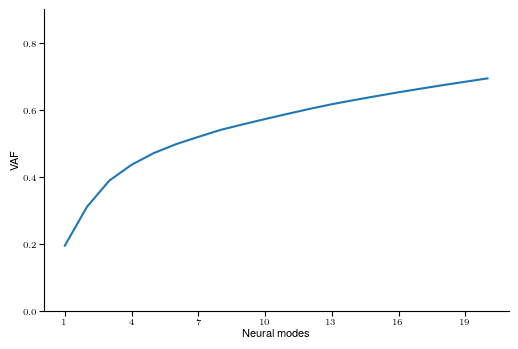

In [34]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # sessionDFs_MCx = get_1session_monkey_data()
    
    plot_vaf(ax, sessionDFs_MCx[2])
    plt.show()

# Part 2

Plot figure

Executed: `get_1session_monkey_data` in 5.5s


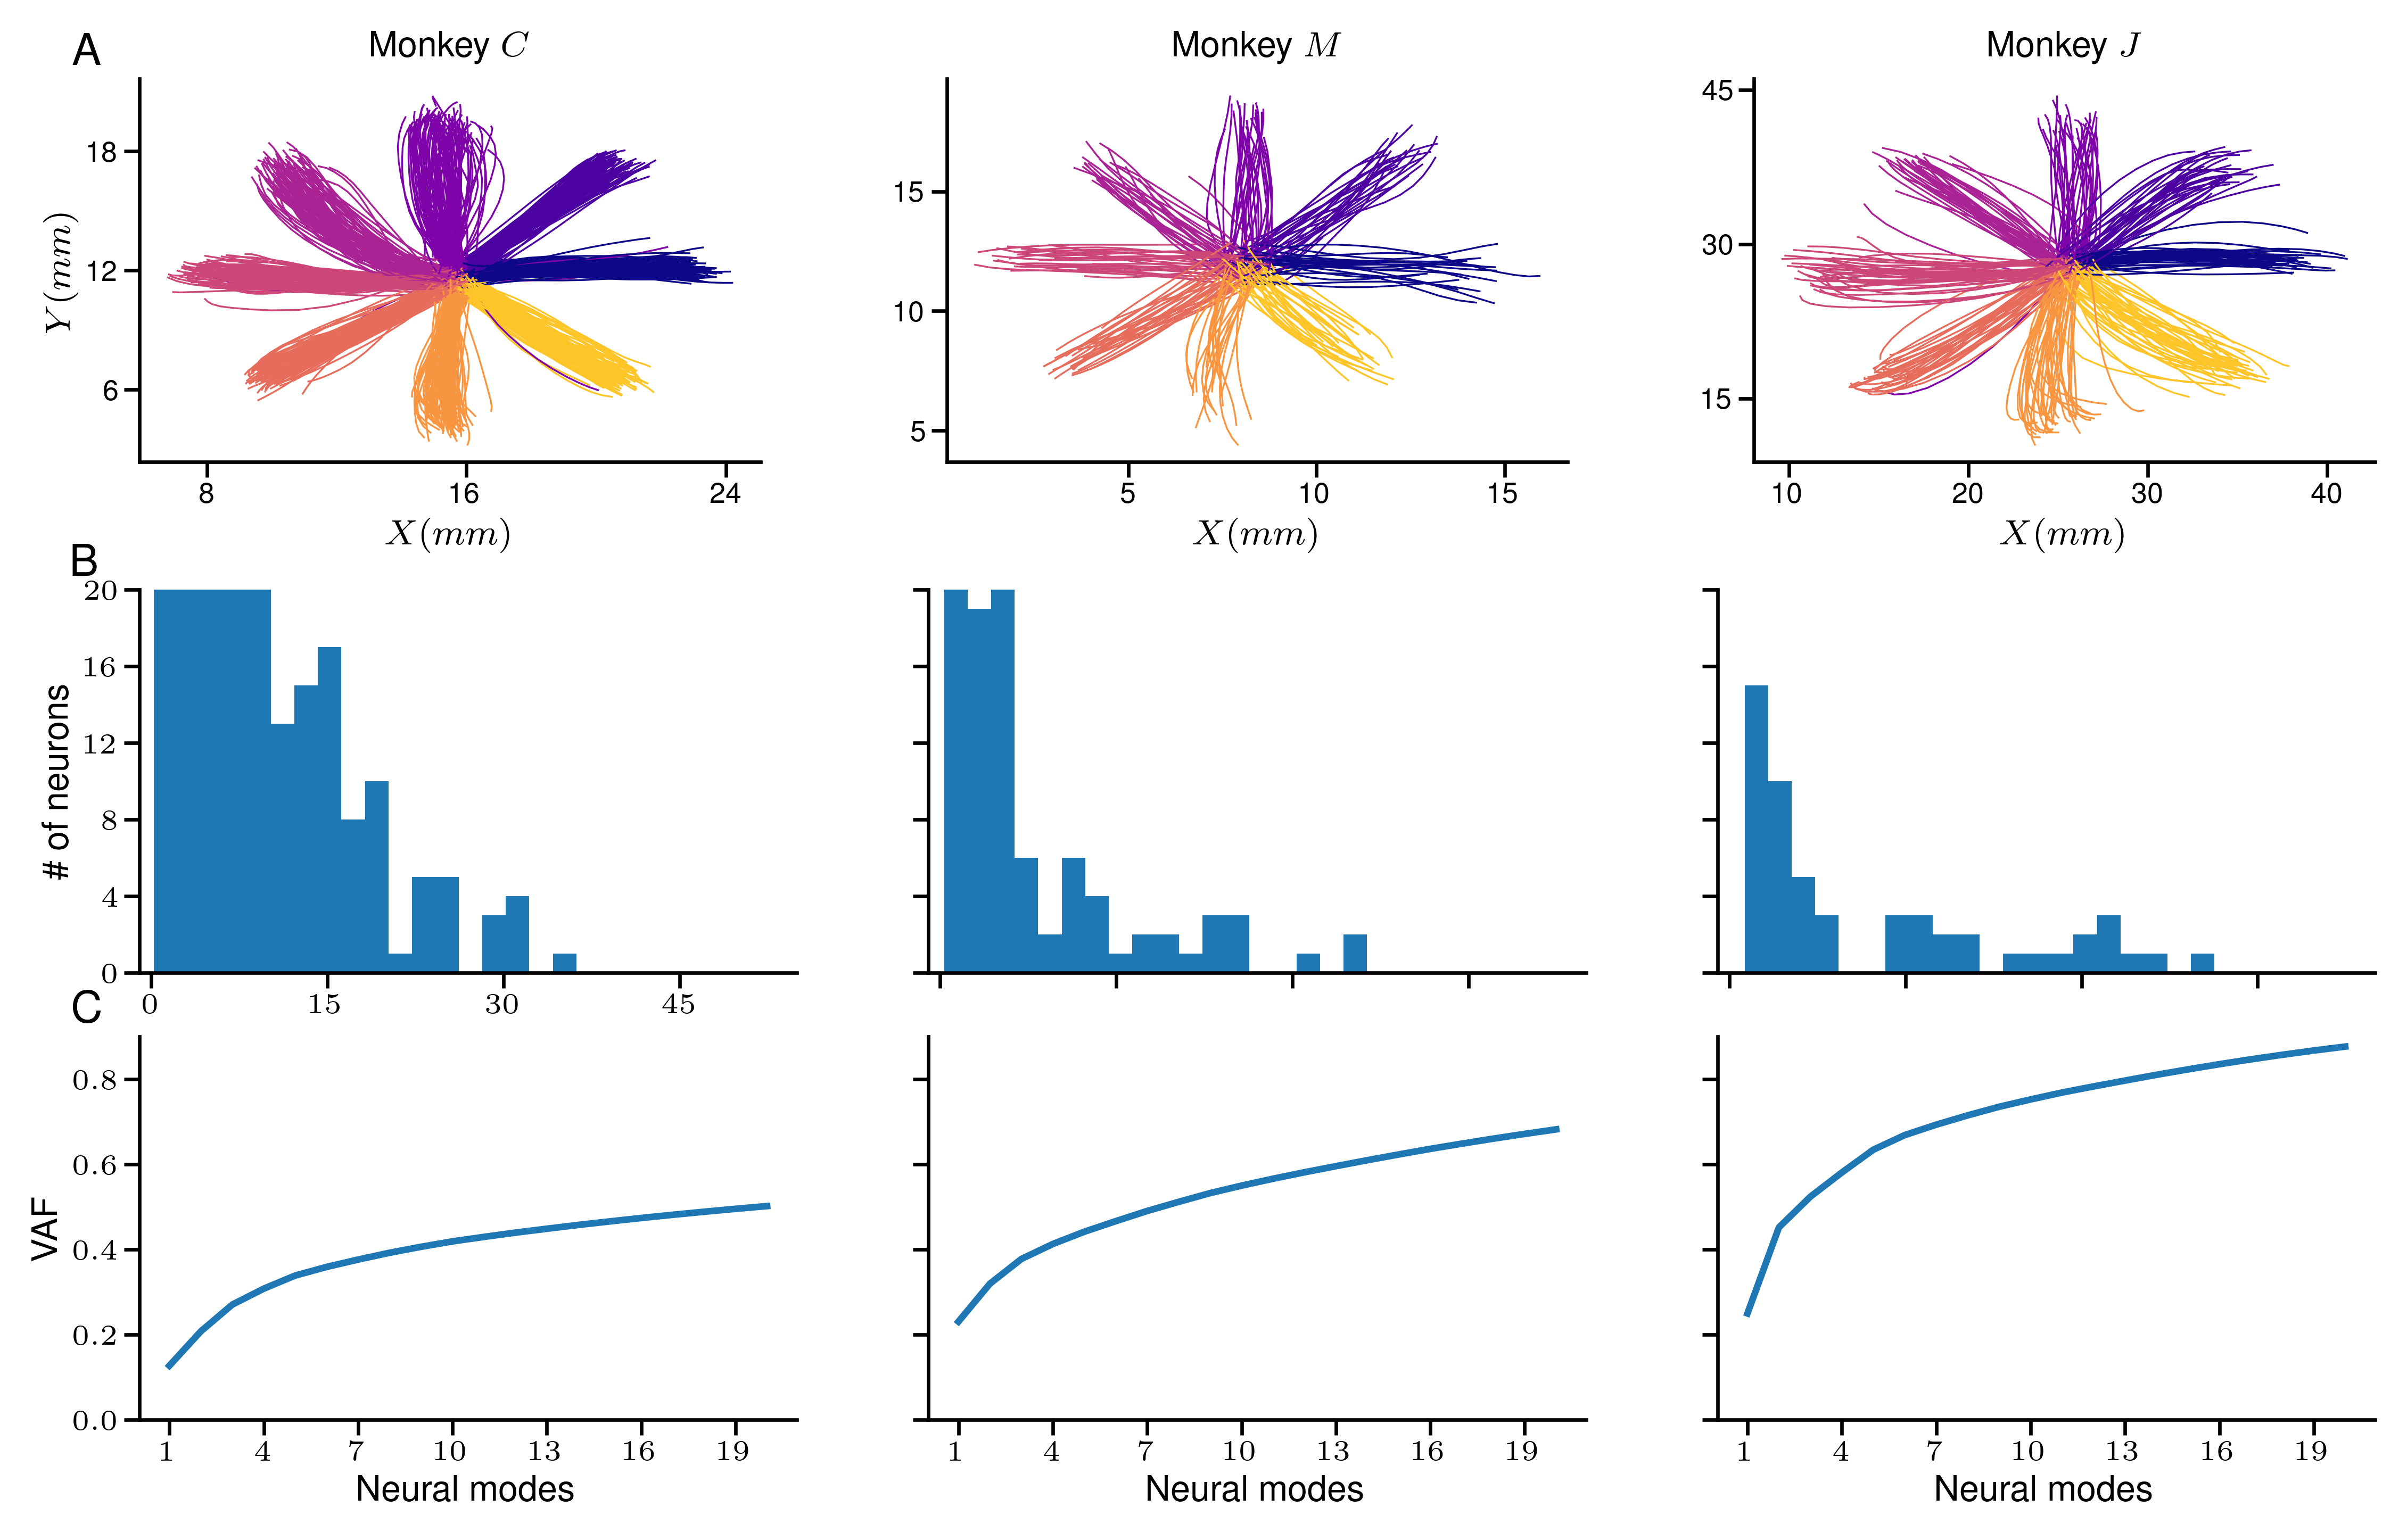

In [50]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   
    sessionDFs_MCx = get_1session_monkey_data()
    
    ##########################################
    # 1: trajectories
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(sessionDFs_MCx), left=0, 
                                    bottom=figsize[1]-params.panels.SmallH, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH,
                                    wspace=.3)
    
    axes1=[]
    for i, df in enumerate(sessionDFs_MCx):
        axes1.append(ax:=fig.add_subplot(gs1[i]))
        plot_traj(ax, df)
        ax.set_title(f'Monkey ${df.monkey[0][0]}$')
        if i>0:
            ax.set_ylabel('')
    
    
    
    ##########################################
    # 2: mean firing rates
    gs2   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(sessionDFs_MCx), left=0, 
                                    bottom=figsize[1]*gs1.bottom-params.panels.SmallH-.4, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH)
    
    axes2=[]
    for i, df in enumerate(sessionDFs_MCx):
        axes2.append(ax:=fig.add_subplot(gs2[i]))
        plot_mean_fr(ax, df, signal = 'MCx_rates', color=params.colors.MouseM1)
        ax.set_xlabel('')
        ax.set_ylim([0,20])
        ax.set_xlim([-1,55])
        if i>0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    
   
    
   
    ##########################################
    # 3: VAF 
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=len(sessionDFs_MCx), left=0, 
                                    bottom=figsize[1]*gs2.bottom-params.panels.SmallH-.2, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH)
    
    axes3=[]
    for i, df in enumerate(sessionDFs_MCx):
        axes3.append(ax:=fig.add_subplot(gs3[i]))
        plot_vaf(ax, df, field = 'MCx_rates', color=params.colors.MouseM1)
        if i>0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
    
    
    
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(axes1[0],axes2[0],axes3[0])
    OFFX=np.array([.03]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS3-monkey-behaviour.pdf', format='pdf', bbox_inches='tight')